In [1220]:
using ClimateMARGO
using Plots

In [1221]:
using ClimateMARGO.Models

In [1222]:
using ClimateMARGO.Diagnostics

In [1223]:
using ClimateMARGO.Utils

In [1224]:
using Random
using Distributions

In [1225]:
using Interpolations

In [1226]:
using CSV, DataFrames

In [1344]:
include("ebm.jl");

In [1345]:
data_path = "GCB2020v18_MtCO2_flat/GCB2020v18_MtCO2_flat.csv"
data = DataFrame(CSV.File(data_path));

In [1346]:
year = data[data[!, "Country"] .== "Global", 3];
q_hist = data[data[!, "Country"] .== "Global", 4]*1e-3;

In [1347]:
interp = extrapolate(interpolate((year,), q_hist, Gridded(Linear())), 0);

In [1348]:
λ_mean = -1.3
λ_var = 0.44
N = 50000

λ_dist = Normal(λ_mean, λ_var);
λ_samples = rand(λ_dist, N);

In [1349]:
λ = quantile(λ_samples, 2/3)
FCO2_double = 4.00
ECS = -FCO2_double/λ

3.6088307246376714

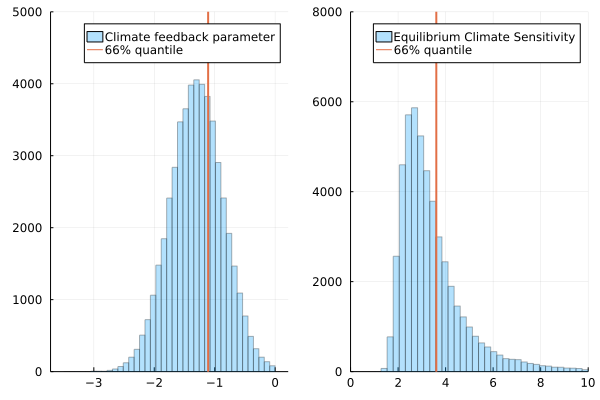

In [1350]:
p1 = histogram(λ_samples, bins=range(-3.5, stop = 0, length = 40), label="Climate feedback parameter", alpha=0.3, ylims=(0, 5000))
vline!(p1, [λ], label="66% quantile", lw=2)
p2 = histogram(-FCO2_double ./ λ_samples, xlims=(0, 10), bins=range(0, stop = 10, length = 40), label="Equilibrium Climate Sensitivity", alpha=0.3, ylims=(0, 8000))
vline!(p2, [ECS], label="66% quantile", lw=2)
p = plot(p1, p2)

In [1351]:
a = [0.2173, 0.2240, 0.2824, 0.2763]
τ = [394.4, 36.54, 4.304]

heavyfunc(f, t) = f .* (t.>=0.)

function IRF(t, a, τ)
    return a[1] .+ sum([aa .* exp.(-t/ττ) for (aa, ττ) in zip(a[2:end], τ)])
end

IRF (generic function with 1 method)

In [1352]:
CO2up(t) = CO2up_land(t) + CO2up_ocean(t)
CO2pulse(t, t0) = heavyfunc(1. .- CO2up(t .- t0), t .- t0)
CO2(t, dt, q, c0) = c0 .+ sum([q[n]*CO2pulse(t, t[n])*dt for n = 1:length(t)])

CO2 (generic function with 1 method)

In [1353]:
params = deepcopy(ClimateMARGO.IO.included_configurations["default"])
m = ClimateModel(params);

phys = m.physics
T0 = phys.T0
c0 = phys.c0
Cd = phys.Cd
κ = phys.κ

a = FCO2_double/log(2.)

Finf = 0.
G = zeros(length(t_arr));

physics = Dict("Δt" => Δt, "Cu" => 7.3, "Cd" => Cd, "κ" => κ, "B" => -λ)

Dict{String,Float64} with 5 entries:
  "B"  => 1.10839
  "Cu" => 7.3
  "κ"  => 0.73
  "Cd" => 106.0
  "Δt" => 1.0

In [1354]:
Δt = 1.
initial_year = 1800
final_year = 2300.
t_arr = collect(initial_year:Δt:final_year)

peak_emission_year = 2020.
E_ = interp(t_arr)
E_max = maximum(E_)
E_[t_arr .>= peak_emission_year] = E_max ./ (1 .+ exp.((t_arr .- peak_emission_year .- 40.) ./ 7.5))[t_arr .>= peak_emission_year]
E_[E_ .< 0.] .= 0.;

In [1355]:
c_ = CO2(t_arr, Δt, GtCO2_to_ppm(E_), c0)
F_ = F(a, c0, Finf, c_, G)
T_ = DICE_EBM(t_arr, Δt, F_, physics=physics);
Ecum_ = cumsum(E_);

In [1356]:
interp_TCRE = extrapolate(interpolate((Ecum_[1:nmax],), T_[1:nmax], Gridded(Linear())), 0);
x = 0:10:maximum(Ecum_[1:nmax]);
y = interp_TCRE(x);
βhat = inv(transpose(x)*x) * transpose(x) * y;
yhat = x*βhat

xplot = 0:10:5000;
yhatplot = xplot*βhat
plot!(xplot, yhatplot, lw=1.5, color=:black, label="")

tn_present = findmin(abs.(t_arr .- 2020))[2]
n_present = findmin(abs.(x .- Ecum_[tn_present]))[2]
RCB = sum(x[n:end])

T_limit = 1.5
n_limit = findmin(abs.(yhat .- T_limit))[2]

plot!([x[n_present]], [yhat[n_present]], marker=:star, markersize=8, color=:red, linewidth=0., label="2020", ylim=(0., 2.3), xlim=(0, 3500))
plot!([x[n_limit]], [yhat[n_limit]], marker=:circle, markersize=8, color=:red, linewidth=0., label="2020", ylim=(0., 2.3), xlim=(0, 3500))

RCB = x[n_limit] - x[n_present]

years_to_net_zero = 2*RCB/qmax

net_zero_year = peak_emission_year + years_to_net_zero
tn_net_zero = findmin(abs.(t_arr .- net_zero_year))[2]

E_net_zero = interp(t_arr)
E_net_zero[(t_arr .>= peak_emission_year) .& (t_arr .< net_zero_year)] .= E_max
E_net_zero[t_arr .>= peak_emission_year] = (E_max * (1 .- (t_arr .- peak_emission_year)/(net_zero_year - peak_emission_year)))[t_arr .>= peak_emission_year]
E_net_zero[E_net_zero .< 0.] .= 0.;

In [1357]:
c_net_zero = CO2(t_arr, Δt, GtCO2_to_ppm(E_net_zero), c0)
F_net_zero = F(a, c0, Finf, c_net_zero, G)
T_net_zero = DICE_EBM(t_arr, Δt, F_net_zero, physics=physics);
Ecum_net_zero = cumsum(E_net_zero);

In [1358]:
c_stab = deepcopy(c_net_zero)
cmax, n_cmax = findmax(c_stab)
c_stab[n_cmax:end] .= cmax
F_stab = F(a, c0, Finf, c_stab, G)
T_stab = DICE_EBM(t_arr, Δt, F_stab, physics=physics);

In [1512]:
E_smooth = interp(t_arr)
E_smooth[t_arr .>= peak_emission_year] = E_max ./ (1 .+ exp.((t_arr .- peak_emission_year .- years_to_net_zero/2) ./ 3.5))[t_arr .>= peak_emission_year]
E_smooth[E_smooth .< 0.] .= 0.;

c_smooth = CO2(t_arr, Δt, GtCO2_to_ppm(E_smooth), c0)
F_smooth = F(a, c0, Finf, c_smooth, G)
T_smooth = DICE_EBM(t_arr, Δt, F_smooth, physics=physics);
Ecum_smooth = cumsum(E_smooth);

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /Users/hdrake/.julia/packages/Plots/g9iOb/src/backends/gr.jl:498


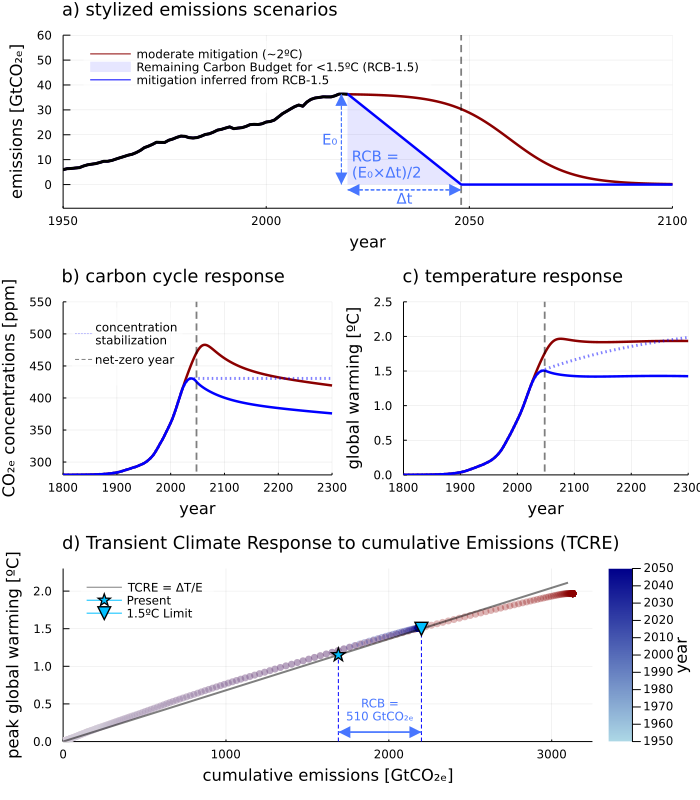

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots /Users/hdrake/.julia/packages/Plots/g9iOb/src/backends/gr.jl:498


In [1515]:
p1 = plot(t_arr, E_, color=:darkred, linewidth=2.5, label="moderate mitigation (~2ºC)")
idx = tn_present:1:tn_net_zero
plot!(t_arr[idx], E_net_zero[idx], fillrange=[E_net_zero[idx].*0., E_net_zero[idx]], fillalpha=0.1, c=:blue, lw=0, label="Remaining Carbon Budget for <1.5ºC (RCB-1.5)")
#plot!(t_arr, E_smooth, xlim=(1950, 2100), ylim=(-9.5, 60.), color=:blue, linewidth=1.5, alpha=0.3, label=nothing)
plot!(t_arr, E_net_zero, xlim=(1950, 2100), ylim=(-9.5, 60.), color=:blue, linewidth=2.5, label="mitigation inferred from RCB-1.5")
plot!(legend=:topleft, background_color_legend=RGBA(1., 1., 1., 0.5), foreground_color_legend=RGBA(0., 0., 0., 0.))
plot!(t_arr[1:tn_present], E_[1:tn_present], color=:black, linewidth=3, label=nothing)
vline!([net_zero_year], color=:black, alpha=0.5, linestyle=:dash, label=nothing, linewidth=1.8)
plot!(xlabel="year", ylabel="emissions [GtCO₂ₑ]", title="a) stylized emissions scenarios", titlefont=font(12), titleloc=:left)
plot!([peak_emission_year, net_zero_year], [-2.15, -2.15],arrow=arrow(:closed,:both), linestyle=:dash, linewidth=0.9, markersize=1., color=:royalblue1, label=nothing)
plot!([peak_emission_year-1.5, peak_emission_year-1.5], [0, Emax],arrow=arrow(:closed,:both), linestyle=:dash, linewidth=0.9, markersize=1., color=:royalblue1, label=nothing)
annotate!(peak_emission_year+years_to_net_zero/20, 1.5, text(string("RCB =\n(E₀×Δt)/2"), :royalblue1, :bottom, :left, 10))
annotate!(peak_emission_year+years_to_net_zero/2, -5.5, text(string("Δt"), :royalblue1, :center, 10))
annotate!(peak_emission_year-4.25, Emax/2., text(string("E₀"), :royalblue1, :center, 10))

p2 = plot(t_arr, c_, color=:darkred, linewidth=2.5, label=nothing)
#plot!(t_arr, c_smooth, color=:blue, linewidth=1.5, alpha=0.3, label=nothing)
plot!(t_arr, c_net_zero, color=:blue, linewidth=2.5, label=nothing)
plot!(t_arr, c_stab, xlim=(1800, 2300), ylim=(280, 550), color=:blue, linewidth=3., alpha=0.5, linestyle=:dot, label="concentration\nstabilization")
plot!(legend=:topleft, background_color_legend=RGBA(1., 1., 1., 0.5), foreground_color_legend=RGBA(0., 0., 0., 0.))
vline!([net_zero_year], color=:black, alpha=0.5, linestyle=:dash, label="net-zero year", linewidth=1.8)
plot!(xlabel="year", ylabel="CO₂ₑ concentrations [ppm]", title="b) carbon cycle response", titlefont=font(12), titleloc=:left)

p3 = plot(t_arr, T_, color=:darkred, linewidth=2.5, label=nothing)
plot!(t_arr, T_net_zero, color=:blue, linewidth=2.5, label=nothing)
plot!(t_arr, T_stab, xlim=(1800, 2300), ylim=(0., 2.5), color=:blue, linewidth=3., alpha=0.5, linestyle=:dot, label=nothing)
vline!([net_zero_year], color=:black, alpha=0.5, linestyle=:dash, label=nothing, linewidth=1.8)
plot!(xlabel="year", ylabel="global warming [ºC]", title="c) temperature response", titlefont=font(12), titleloc=:left)

p4 = plot()
for n in 1:length(t_arr)
    plot!([Ecum_[n]], [maximum(T_[1:n])],  marker=:dot, marker_z=[t_arr[n]], markersize=4., markerstrokewidth=0., color=:reds, alpha=0.3, clim=(1950, 2050), label=nothing)
    plot!([Ecum_net_zero[n]], [maximum(T_net_zero[1:n])], marker=:dot, marker_z=[t_arr[n]], markersize=4., markerstrokewidth=0., color=:blues, alpha=0.3, clim=(1950, 2050), label=nothing)
end

plot!(colorbar_title = "year")
plot!(x, yhat, linewidth=2., color=:black, alpha=0.5, label="TCRE = ΔT/E")

plot!([x[n_present], x[n_present]], [0., yhat[n_present]], color=:blue, linestyle=:dash, label=nothing)
plot!([x[n_limit], x[n_limit]], [0., yhat[n_limit]], color=:blue, linestyle=:dash, label=nothing)

plot!([x[n_present]], [yhat[n_present]], marker=:star, markersize=7, color=:deepskyblue, linewidth=0., label="Present", ylim=(0., 2.3), xlim=(0, 3250))
plot!([x[n_limit]], [yhat[n_limit]], marker=:dtriangle, markersize=6.5, color=:deepskyblue, linewidth=0., label="1.5ºC Limit", ylim=(0., 2.3), xlim=(0, 3250))
plot!(legend=:topleft, background_color_legend=RGBA(1., 1., 1., 0.5), foreground_color_legend=RGBA(0., 0., 0., 0.))
plot!(xlabel="cumulative emissions [GtCO₂ₑ]", ylabel="peak global warming [ºC]")
plot!(title="d) Transient Climate Response to cumulative Emissions (TCRE)", titlefont=font(12), titleloc=:left)

plot!([x[n_present], x[n_limit]], [0.125, 0.125],arrow=arrow(:closed,:both), color=:royalblue1, label=nothing)
annotate!(x[n_present]+RCB/2., 0.425, text(string("RCB =\n",Int64(round(RCB))," GtCO₂ₑ"), :royalblue1, :center, 8))

l = @layout [a; b c; d]
p = plot(p1, p2, p3, p4, layout=l, size=(700, 800))

savefig(p, "TCRE.pdf");
p

In [1495]:
FCO2_double/(-λ)

3.6088307246376714

In [1518]:
years_to_net_zero


27.990152622502052